# Load cuebiq and convert to aggregated travel demand each 10min interval

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format
import matplotlib.pyplot as plt
import geopandas as gpd

In [4]:
# df_stops = pd.read_pickle("./data/cuebiq/texas_stops_20221010_20221023.pkl")
# print(df_stops.shape[0])
# print(df_stops.cuebiq_id.unique().shape[0])

4017828
182113


In [6]:
%%time
df_stops = pd.read_pickle("./data/cuebiq/texas_stops_20221017_20221023.pkl")   #texas_stops_20221017_20221023.pkl, texas_stops_20221010_20221016
# df_stops['Time'] = df_stops['stop_zoned_datetime'].astype(str).str[0:-6]
# df_stops.drop(['stop_zoned_datetime'], axis=1, inplace=True)
df_stops['Time'] = pd.to_datetime(df_stops['Time'], errors='coerce')
print(df_stops.shape[0])
print(df_stops.cuebiq_id.unique().shape[0])
df_stops.head(2)

2021957
137934
CPU times: user 3.26 s, sys: 1.16 s, total: 4.42 s
Wall time: 5.8 s


,cuebiq_id,device_type_code,os_name,lat,lng,geohash_id,cluster_size,avg_distance_meters,avg_accuracy_meters,std_accuracy_meters,dwell_time_minutes,timezone_offset_seconds,admin1_id,admin2_id,classification_type,transformation_type,block_group_id,processing_date,country_code,provider_id,event_date,Time
241551,6095778741,GAID,ANDROID,30.15965,-97.86016,9v67t4kkt,10,2.08316,3.79000,0.00000,9.10000,-18000,US.TX,US.TX.453,OTHER,KEEP,US.TX.453.001775.1,20221017,US,LIMA,2022-10-17,2022-10-17 13:16:23
241552,6095778741,GAID,ANDROID,30.21801,-97.76048,9v67zmhbx,7,1.18294,3.79000,0.00000,5.60000,-18000,US.TX,US.TX.453,WHITELISTED,KEEP,US.TX.453.002403.1,20221017,US,LIMA,2022-10-17,2022-10-17 12:46:03


In [7]:
df_stops_need = df_stops[['cuebiq_id','lat','lng','event_date','Time','dwell_time_minutes']]
df_stops_need['departure_time'] = df_stops_need['Time'] + pd.to_timedelta(df_stops_need['dwell_time_minutes'], unit='m')
df_stops_need = df_stops_need[['cuebiq_id','lat','lng','departure_time']]
df_stops_need.head()

import geopandas as gpd

gdf_stops = gpd.GeoDataFrame(
    df_stops_need,
    geometry=gpd.points_from_xy(df_stops_need.lng, df_stops_need.lat),
    crs="EPSG:4326"
)

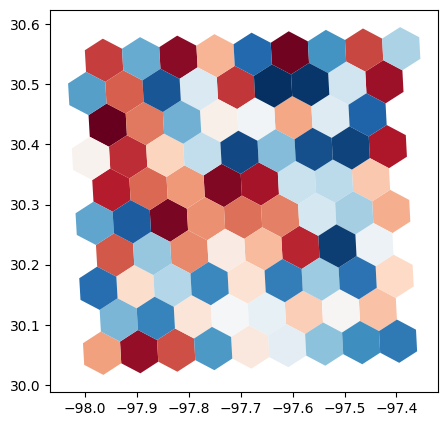

In [2]:
from shapely.geometry import box
import geopandas as gpd
import h3pandas

bound_lat = [30.039047,30.584984]
bound_lon = [-97.996048, -97.389445]
austin_box = gpd.GeoDataFrame(geometry=[box(bound_lon[0],bound_lat[0],bound_lon[1],bound_lat[1])],crs="EPSG:4326")
# austin_box.plot()


resolution = 6 # Average edge length: 3.7km
# H3 resolution list: https://h3geo.org/docs/core-library/restable/
hexagons = austin_box.h3.polyfill_resample(resolution)
ax = hexagons.plot(figsize=(5, 5), cmap='RdBu')
hexagons.drop(['index'], axis=1, inplace=True)

In [9]:
gdf_stops['no_devices'] = 1
print(gdf_stops.shape[0])
no_devices = gpd.sjoin(gdf_stops, hexagons, predicate='within') 
print(no_devices.shape[0])

2021957
1980966


In [10]:
%%time
no_devices['departure_time_10min_interval'] = no_devices['departure_time'].dt.floor('10T') # rounds down each datetime value to the nearest 10-minute interval
no_devices['date'] = no_devices['departure_time_10min_interval'].dt.date    # Extract date (YYYY-MM-DD)
no_devices['hour_min'] = no_devices['departure_time_10min_interval'].dt.strftime('%H:%M')  # Extract hour and minute (HH:MM)

hexagon_no_departures = no_devices[['h3_polyfill','no_devices','date','hour_min']].groupby(['h3_polyfill','date','hour_min']).sum().reset_index()
hexagon_no_departures = hexagon_no_departures.merge(hexagons,left_on='h3_polyfill',right_on=hexagons.index)
hexagon_no_departures = gpd.GeoDataFrame(hexagon_no_departures, crs="EPSG:4326", geometry='geometry')
hexagon_no_departures = hexagon_no_departures.rename(columns={"index_right": "hex_index"})
hexagon_no_departures['date'] = hexagon_no_departures['date'].astype(str)

print(hexagon_no_departures.shape[0])
hexagon_no_departures.head()

58451
CPU times: user 8.75 s, sys: 108 ms, total: 8.86 s
Wall time: 8.91 s


,h3_polyfill,date,hour_min,no_devices,geometry
0,864898507ffffff,2022-10-17,02:10,1,"POLYGON ((-97.88925 30.5066, -97.85461 30.52584, -97.85695 30.5618, -97.89395 30.57852, -97.9286 30.55927, -97.92624 30.52331, -97.88925 30.5066))"
1,864898507ffffff,2022-10-17,03:00,1,"POLYGON ((-97.88925 30.5066, -97.85461 30.52584, -97.85695 30.5618, -97.89395 30.57852, -97.9286 30.55927, -97.92624 30.52331, -97.88925 30.5066))"
2,864898507ffffff,2022-10-17,05:20,1,"POLYGON ((-97.88925 30.5066, -97.85461 30.52584, -97.85695 30.5618, -97.89395 30.57852, -97.9286 30.55927, -97.92624 30.52331, -97.88925 30.5066))"
3,864898507ffffff,2022-10-17,06:00,1,"POLYGON ((-97.88925 30.5066, -97.85461 30.52584, -97.85695 30.5618, -97.89395 30.57852, -97.9286 30.55927, -97.92624 30.52331, -97.88925 30.5066))"
4,864898507ffffff,2022-10-17,06:10,2,"POLYGON ((-97.88925 30.5066, -97.85461 30.52584, -97.85695 30.5618, -97.89395 30.57852, -97.9286 30.55927, -97.92624 30.52331, -97.88925 30.5066))"


In [12]:
%%time

df_road = pd.read_csv("data/TMC_Identification.csv", sep=',', header=0)
df_road = df_road[['tmc_code','intersection','start_latitude','start_longitude','end_latitude','end_longitude','miles']]
print('total number of road segments:',df_road.shape[0])
from shapely.geometry import LineString

df_road['geometry'] = df_road.apply(
    lambda row: LineString([(row['start_longitude'], row['start_latitude']),
                             (row['end_longitude'], row['end_latitude'])]),
    axis=1
)

# Create a GeoDataFrame for road network
gdf_road = gpd.GeoDataFrame(df_road, geometry='geometry',crs="EPSG:4326")

total number of road segments: 4460
CPU times: user 148 ms, sys: 4.48 ms, total: 153 ms
Wall time: 244 ms


In [13]:
date1 = '2022-10-21'
hour_min1 = '13:20'

m = hexagon_no_departures[(hexagon_no_departures['date']==date1)&(hexagon_no_departures['hour_min']==hour_min1)].explore(
    column='no_devices'
)

gdf_road.explore(
    m=m
)

## Assign travel demand to each road segment by spatial join hexagons and road segments

In [21]:
%%time
# road_segments_with_stops = gpd.sjoin(gdf_road, hexagon_no_departures, how='inner', predicate='intersects')
road_segments_with_stops = gpd.sjoin_nearest(
    hexagon_no_departures,
    gdf_road,
    how='left',  # Use 'left' to ensure all road segments are preserved
)
print(road_segments_with_stops.shape[0]) #4594497
road_segments_with_stops.head(2)

4595263
CPU times: user 9.17 s, sys: 384 ms, total: 9.55 s
Wall time: 9.55 s


,h3_polyfill,date,hour_min,no_devices,geometry,index_right,tmc_code,intersection,start_latitude,start_longitude,end_latitude,end_longitude,miles
0,864898507ffffff,2022-10-17,02:10,1,"POLYGON ((-97.88925 30.5066, -97.85461 30.52584, -97.85695 30.5618, -97.89395 30.57852, -97.9286 30.55927, -97.92624 30.52331, -97.88925 30.5066))",4216,112-19724,N LAKELINE BLVD,30.58082,-97.85949,30.56981,-97.89372,2.17517
0,864898507ffffff,2022-10-17,02:10,1,"POLYGON ((-97.88925 30.5066, -97.85461 30.52584, -97.85695 30.5618, -97.89395 30.57852, -97.9286 30.55927, -97.92624 30.52331, -97.88925 30.5066))",2895,112-50364,RM-1431/W WHITESTONE BLVD,30.52712,-97.85550,30.51443,-97.85114,0.92197


In [22]:
df_travel_demand_each10min = road_segments_with_stops.groupby(['tmc_code','date','hour_min'])['no_devices'].sum().reset_index()
df_travel_demand_each10min['date'] = df_travel_demand_each10min['date'].astype(str)
print(df_travel_demand_each10min.shape[0])
df_travel_demand_each10min.head()

4104144


,tmc_code,date,hour_min,no_devices
0,112+04758,2022-10-17,00:00,2
1,112+04758,2022-10-17,00:10,7
2,112+04758,2022-10-17,00:20,7
3,112+04758,2022-10-17,00:30,7
4,112+04758,2022-10-17,00:40,6


In [23]:
df_travel_demand_each10min.no_devices.describe()

count   4104144.00000
mean    102.28365    
std     124.78228    
min     1.00000      
25%     13.00000     
50%     56.00000     
75%     145.00000    
max     1149.00000   
Name: no_devices, dtype: float64

In [24]:
df_travel_demand_each10min.to_csv('./output/travel_demand_inrix_road_part2.csv',index=False) #travel_demand_inrix_road_part1

In [ ]:
df_travel_demand_each10min_select = df_travel_demand_each10min[(df_travel_demand_each10min['date']==date1)&(df_travel_demand_each10min['hour_min']==hour_min1)]
df_travel_demand_each10min_select
gdf_road_explore = gdf_road.merge(df_travel_demand_each10min_select)
gdf_road_explore.shape[0]
%%time
gdf_road_explore.explore(
    column='no_devices'
)

# compute diff in travel demand for the week of 2022.10.17-10.23 using last week as benchmark

In [5]:
df_travel_demand_each10min = pd.read_csv('./output/travel_demand_inrix_road_part2.csv')
df_travel_demand_each10min.head()

,tmc_code,date,hour_min,no_devices
0,112+04758,2022-10-17,00:00,2
1,112+04758,2022-10-17,00:10,7
2,112+04758,2022-10-17,00:20,7
3,112+04758,2022-10-17,00:30,7
4,112+04758,2022-10-17,00:40,6


In [26]:
df_pastweek = pd.read_csv('./output/travel_demand_inrix_road_part1.csv')
df_pastweek.head(2)

,tmc_code,date,hour_min,no_devices
0,112+04758,2022-10-10,00:00,1
1,112+04758,2022-10-10,00:10,7


In [28]:
df_all_demand = pd.concat([df_travel_demand_each10min,df_pastweek], axis=0)
print(df_all_demand.shape[0])

8207617


In [30]:
df_all_demand.date.unique()

array(['2022-10-17', '2022-10-18', '2022-10-19', '2022-10-20',
       '2022-10-21', '2022-10-22', '2022-10-23', '2022-10-24',
       '2022-10-10', '2022-10-11', '2022-10-12', '2022-10-13',
       '2022-10-14', '2022-10-15', '2022-10-16'], dtype=object)

In [31]:
%%time

df_diff_all = pd.DataFrame()

for day_pair in [['2022-10-10','2022-10-17'],['2022-10-11','2022-10-18'],['2022-10-12','2022-10-19'],['2022-10-13','2022-10-20'],
                 ['2022-10-14','2022-10-21'],['2022-10-15','2022-10-22'],['2022-10-16','2022-10-23']]:
    day1, day2 = day_pair[0],day_pair[1]
    print(day1, day2)
    
    df_baseline = df_all_demand[df_all_demand['date']==day1].sort_values(by=['tmc_code','hour_min'], ascending=True)
    
    df_focus = df_all_demand[df_all_demand['date']==day2].sort_values(by=['tmc_code','hour_min'], ascending=True)
    
    print(df_baseline.shape[0], df_focus.shape[0])

    df_diff = pd.merge(
        df_baseline[['tmc_code', 'hour_min','no_devices']],
        df_focus[['tmc_code','hour_min', 'no_devices']],
        on=['tmc_code','hour_min'],
        suffixes=('_baseline', '_focus')
    )
    
    # Calculate the delay difference
    df_diff['demand_diff'] = df_diff['no_devices_focus'] - df_diff['no_devices_baseline']
    
    df_diff['date'] = day2

    df_diff_all = pd.concat([df_diff_all, df_diff], ignore_index=True)

2022-10-10 2022-10-17
515144 931823
2022-10-11 2022-10-18
527380 527638
2022-10-12 2022-10-19
527509 528334
2022-10-13 2022-10-20
529017 529053
2022-10-14 2022-10-21
529186 530720
2022-10-15 2022-10-22
529673 529938
2022-10-16 2022-10-23
528721 529113
CPU times: user 12.9 s, sys: 231 ms, total: 13.1 s
Wall time: 13.1 s


In [33]:
df_diff_all.to_csv('./output/travel_demand_inrix_road_final.csv',index=False)